In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import csv
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import text_to_word_sequence
import re, os
from keras.models import Model

from keras.layers import Input
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import LSTM, Bidirectional
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from tqdm import tqdm
import time
from datetime import datetime
import json
import warnings
warnings.simplefilter("ignore", UserWarning)
seed = 7
np.random.seed(seed)

Using TensorFlow backend.


In [2]:
maxlen = 300 # Cuts off reviews after 100 words
training_samples = 2000 # Trains on 200 samples
validation_samples = 10000 # Validates on 10,000 samples
max_words = 10000 # Considers only the top 10,000 words in the dataset

In [3]:
# O model será exportado para este arquivo
filename='model_saved.h5'
epochs = 4
# dimensionalidade do word embedding pré-treinado
word_embedding_dim = 50
# número de amostras a serem utilizadas em cada atualização do gradiente
batch_size = 32
# Reflete a quantidade máxima de palavras que iremos manter no vocabulário
max_fatures = 10000
# dimensão de saída da camada Embedding
embed_dim = 128
# limitamos o tamanho máximo de todas as sentenças
max_sequence_length = 300
pre_trained_wv = True
bilstm = False

def clean_str(string):
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)

    cleanr = re.compile('<.*?>')

    string = re.sub(r'\d+', '', string)
    string = re.sub(cleanr, '', string)
    string = re.sub("'", '', string)
    string = re.sub(r'\W+', ' ', string)
    string = string.replace('_', '')


    return string.strip().lower()

In [4]:
def prepare_data(data):    
    data = data[['text_pt','sentiment']]

    data['text'] = data['text_pt'].apply(lambda x: x.lower())
    data['text'] = data['text_pt'].apply(lambda x: clean_str(x))
    
    stop_words = set(stopwords.words('portuguese'))
    text = []
    for row in data['text'].values:
        word_list = text_to_word_sequence(row)
        no_stop_words = [w for w in word_list if not w in stop_words]
        no_stop_words = " ".join(no_stop_words)
        text.append(no_stop_words)


    tokenizer = Tokenizer(num_words=max_fatures, split=' ')

    tokenizer.fit_on_texts(text)
    X = tokenizer.texts_to_sequences(text)  
    
    X = pad_sequences(X, maxlen=max_sequence_length)
    word_index = tokenizer.word_index
    Y = pd.get_dummies(data['sentiment']).values
    X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.20, random_state = 42)

    return X_train, X_test, Y_train, Y_test, word_index, tokenizer


def load_pre_trained_wv(word_index, num_words, word_embedding_dim):
    embeddings_index = {}
    f = open(os.path.join('../input/glove-s50/glove_s50/', 'glove_s{}.txt'.format(word_embedding_dim)), encoding='utf-8')
    for line in tqdm(f):
        values = line.rstrip().rsplit(' ')
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
    f.close()

    print('%s word vectors.' % len(embeddings_index))
    
    embedding_dim = 50
    embedding_matrix = np.zeros((max_words, embedding_dim))
    for word, i in word_index.items():
        if i < max_words:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector #Words not found in the embedding index will be all zeros.         

    return embedding_matrix

In [5]:

data = pd.read_csv("../input/imdbpt/imdb1/imdb/imdb-reviews-pt-br.csv")
data.head()

,id,text_en,text_pt,sentiment
0,1,Once again Mr. Costner has dragged out a movie...,"Mais uma vez, o Sr. Costner arrumou um filme p...",neg
1,2,This is an example of why the majority of acti...,Este é um exemplo do motivo pelo qual a maiori...,neg
2,3,"First of all I hate those moronic rappers, who...","Primeiro de tudo eu odeio esses raps imbecis, ...",neg
3,4,Not even the Beatles could write songs everyon...,Nem mesmo os Beatles puderam escrever músicas ...,neg
4,5,Brass pictures movies is not a fitting word fo...,Filmes de fotos de latão não é uma palavra apr...,neg


In [6]:
X_train, X_test, Y_train, Y_test, word_index, tokenizer = prepare_data(data)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


(39567, 300) (39567, 2)
(9892, 300) (9892, 2)


# 1

In [7]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
embedding_dim = 50
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 300, 50)           500000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 15000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                480032    
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 980,098
Trainable params: 980,098
Non-trainable params: 0
_________________________________________________________________


In [ ]:
print(len(word_index))
print(num_words)
print(word_embedding_dim)

In [8]:
num_words = min(max_fatures, len(word_index) + 1)
embedding_matrix = load_pre_trained_wv(word_index, num_words, word_embedding_dim)
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

929606it [00:18, 51148.06it/s]


929606 word vectors.


In [9]:
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])
hist = model.fit(
        X_train, 
        Y_train, 
        validation_data=(X_test, Y_test),
        epochs=10,
        batch_size=32, 
        shuffle=True,
        verbose=1)

Train on 39567 samples, validate on 9892 samples
Epoch 1/10
39567/39567 [==============================] - 6s 155us/step - loss: 0.5974 - acc: 0.6800 - val_loss: 0.6793 - val_acc: 0.6335
Epoch 2/10
39567/39567 [==============================] - 6s 146us/step - loss: 0.5060 - acc: 0.7523 - val_loss: 0.5676 - val_acc: 0.7171
Epoch 3/10
39567/39567 [==============================] - 6s 147us/step - loss: 0.4518 - acc: 0.7817 - val_loss: 0.6037 - val_acc: 0.6982
Epoch 4/10
39567/39567 [==============================] - 6s 146us/step - loss: 0.3869 - acc: 0.8160 - val_loss: 0.7397 - val_acc: 0.6980
Epoch 5/10
39567/39567 [==============================] - 6s 146us/step - loss: 0.3221 - acc: 0.8550 - val_loss: 0.7971 - val_acc: 0.6813
Epoch 6/10
39567/39567 [==============================] - 6s 147us/step - loss: 0.2566 - acc: 0.8869 - val_loss: 1.0042 - val_acc: 0.6838
Epoch 7/10
39567/39567 [==============================] - 6s 148us/step - loss: 0.1977 - acc: 0.9130 - val_loss: 1.2159 - v

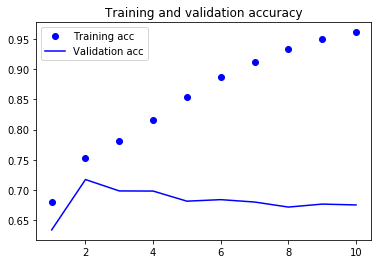

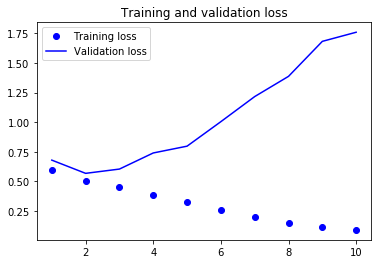

In [12]:

acc = hist.history['acc']
val_acc = hist.history['val_acc']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [10]:
def create_model(p):
    embedding_dim = 50
    model = Sequential()
    model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
    model.add(LSTM(embedding_dim, dropout=p, name="lstm"))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(2, activation='softmax'))
    
    print("Dropout: ", p)
    model.compile(optimizer='rmsprop',
        loss='binary_crossentropy',
        metrics=['acc'])
    hist = model.fit(
        X_train[:5000, :], 
        Y_train[:5000,:], 
        validation_data=(X_test[:2000,:], Y_test[:2000,:]),
        epochs=10,
        batch_size=32, 
        shuffle=True,
        verbose=1)
        
    acc = hist.history['acc']
    val_acc = hist.history['val_acc']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()
    
    return model

# 2. 

Dropout:  0.3
Train on 5000 samples, validate on 2000 samples
Epoch 1/10
5000/5000 [==============================] - 124s 25ms/step - loss: 0.5708 - acc: 0.7002 - val_loss: 0.4843 - val_acc: 0.7720
Epoch 2/10
5000/5000 [==============================] - 124s 25ms/step - loss: 0.2849 - acc: 0.8860 - val_loss: 0.4474 - val_acc: 0.7980
Epoch 3/10
5000/5000 [==============================] - 122s 24ms/step - loss: 0.1914 - acc: 0.9308 - val_loss: 0.4242 - val_acc: 0.8245
Epoch 4/10
5000/5000 [==============================] - 123s 25ms/step - loss: 0.1313 - acc: 0.9538 - val_loss: 0.4803 - val_acc: 0.8075
Epoch 5/10
5000/5000 [==============================] - 123s 25ms/step - loss: 0.0869 - acc: 0.9706 - val_loss: 0.6085 - val_acc: 0.8200
Epoch 6/10
5000/5000 [==============================] - 123s 25ms/step - loss: 0.0671 - acc: 0.9782 - val_loss: 0.6590 - val_acc: 0.8130
Epoch 7/10
5000/5000 [==============================] - 124s 25ms/step - loss: 0.0441 - acc: 0.9864 - val_loss: 0.71

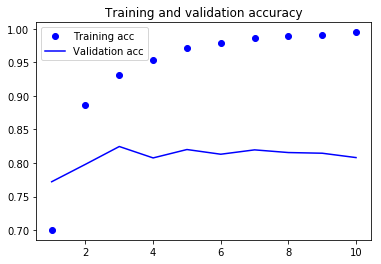

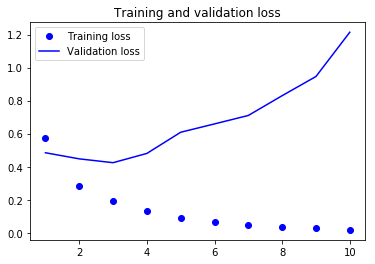

Dropout:  0.4
Train on 5000 samples, validate on 2000 samples
Epoch 1/10
5000/5000 [==============================] - 124s 25ms/step - loss: 0.6218 - acc: 0.6546 - val_loss: 0.4279 - val_acc: 0.8100
Epoch 2/10
5000/5000 [==============================] - 124s 25ms/step - loss: 0.3245 - acc: 0.8666 - val_loss: 0.5800 - val_acc: 0.7455
Epoch 3/10
5000/5000 [==============================] - 122s 24ms/step - loss: 0.2078 - acc: 0.9218 - val_loss: 0.4932 - val_acc: 0.8340
Epoch 4/10
5000/5000 [==============================] - 123s 25ms/step - loss: 0.1472 - acc: 0.9466 - val_loss: 0.5268 - val_acc: 0.8310
Epoch 5/10
5000/5000 [==============================] - 123s 25ms/step - loss: 0.1223 - acc: 0.9616 - val_loss: 0.5471 - val_acc: 0.8070
Epoch 6/10
5000/5000 [==============================] - 123s 25ms/step - loss: 0.0844 - acc: 0.9732 - val_loss: 0.6369 - val_acc: 0.8205
Epoch 7/10
5000/5000 [==============================] - 123s 25ms/step - loss: 0.0614 - acc: 0.9794 - val_loss: 0.68

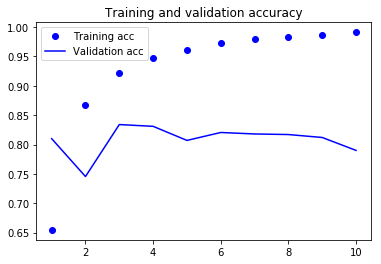

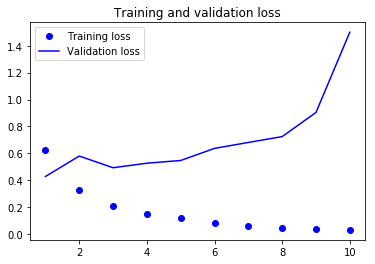

Dropout:  0.5
Train on 5000 samples, validate on 2000 samples
Epoch 1/10
5000/5000 [==============================] - 124s 25ms/step - loss: 0.5926 - acc: 0.6668 - val_loss: 0.4170 - val_acc: 0.8115
Epoch 2/10
5000/5000 [==============================] - 124s 25ms/step - loss: 0.3194 - acc: 0.8718 - val_loss: 0.4071 - val_acc: 0.8450
Epoch 3/10
5000/5000 [==============================] - 123s 25ms/step - loss: 0.2119 - acc: 0.9234 - val_loss: 0.5138 - val_acc: 0.8085
Epoch 4/10
5000/5000 [==============================] - 124s 25ms/step - loss: 0.1578 - acc: 0.9436 - val_loss: 0.4621 - val_acc: 0.8345
Epoch 5/10
5000/5000 [==============================] - 123s 25ms/step - loss: 0.1216 - acc: 0.9574 - val_loss: 0.4353 - val_acc: 0.8305
Epoch 6/10
5000/5000 [==============================] - 123s 25ms/step - loss: 0.0883 - acc: 0.9684 - val_loss: 0.5717 - val_acc: 0.8260
Epoch 7/10
5000/5000 [==============================] - 123s 25ms/step - loss: 0.0720 - acc: 0.9764 - val_loss: 0.66

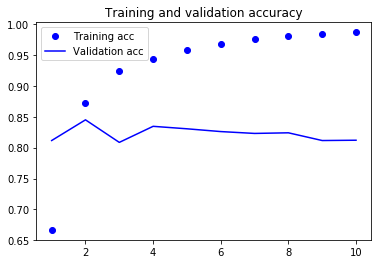

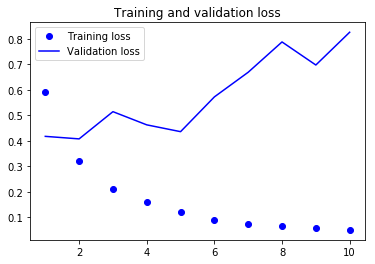

In [13]:
drop = [0.3, 0.4, 0.5]
models = []
for d in drop:
    m = create_model(d)
    models.append(m)   

In [ ]:
def pred(texto):
    model = models[0]
    sentence = clean_str(texto)
    new_text = [sentence]
    new_text = tokenizer.texts_to_sequences(new_text)
    new_text = pad_sequences(new_text, maxlen=max_sequence_length, dtype='int32', value=0)
    sentiment = model.predict(new_text,batch_size=1,verbose = 2)[0]
    if(np.argmax(sentiment) == 0):
        pred_proba = "%.2f%%" % (sentiment[0]*100)
        print("negativo => ", pred_proba)
    elif (np.argmax(sentiment) == 1):
        pred_proba = "%.2f%%" % (sentiment[1]*100)
        print("positivo => ", pred_proba)

In [20]:
pred("O filme é ruim")

negativo =>  84.65%


In [26]:
pred("O filme é maravilhoso")

positivo =>  93.51%


In [17]:
pred("O filme não presta")

negativo =>  59.06%


# 3

In [18]:
embedding_dim = 50
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Bidirectional(LSTM(embedding_dim, name="lstm")))
model.add(Dense(2, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 300, 50)           500000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 100)               40400     
_________________________________________________________________
dense_15 (Dense)             (None, 2)                 202       
Total params: 540,602
Trainable params: 540,602
Non-trainable params: 0
_________________________________________________________________


In [27]:
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])
hist = model.fit(
        X_train[:5000,:], 
        Y_train[:5000,:], 
        validation_data=(X_test[:200,:], Y_test[:200,:]),
        epochs=10,
        batch_size=32, 
        shuffle=True,
        verbose=1)

Train on 5000 samples, validate on 200 samples
Epoch 1/10
5000/5000 [==============================] - 208s 42ms/step - loss: 0.2640 - acc: 0.8986 - val_loss: 0.4438 - val_acc: 0.7800
Epoch 2/10
5000/5000 [==============================] - 207s 41ms/step - loss: 0.1554 - acc: 0.9466 - val_loss: 0.4933 - val_acc: 0.8100
Epoch 3/10
5000/5000 [==============================] - 207s 41ms/step - loss: 0.0987 - acc: 0.9694 - val_loss: 0.5101 - val_acc: 0.8300
Epoch 4/10
5000/5000 [==============================] - 206s 41ms/step - loss: 0.0599 - acc: 0.9818 - val_loss: 0.8480 - val_acc: 0.7900
Epoch 5/10
5000/5000 [==============================] - 207s 41ms/step - loss: 0.0402 - acc: 0.9872 - val_loss: 0.6777 - val_acc: 0.8000
Epoch 6/10
5000/5000 [==============================] - 206s 41ms/step - loss: 0.0287 - acc: 0.9920 - val_loss: 0.8125 - val_acc: 0.7800
Epoch 7/10
5000/5000 [==============================] - 205s 41ms/step - loss: 0.0229 - acc: 0.9946 - val_loss: 0.9807 - val_acc: 0

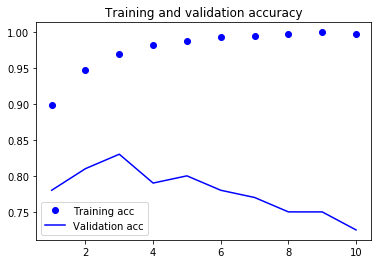

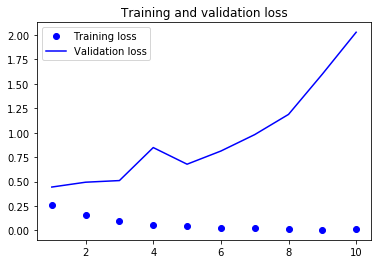

In [29]:
acc = hist.history['acc']
val_acc = hist.history['val_acc']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()